# Data exploration

In [1]:
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Get the current working directory
current_dir = os.getcwd()

# Define the path to the data
data_path = os.path.join(current_dir, 'data')

print(f"Data path: {data_path}")

Data path: c:\Users\lucha\Documents\GitHub\semester-project-global-warming\data


In [2]:
print("Loading the data...")
# Load the data
with open(os.path.join(data_path, 'ssp585_time_series.pkl'), 'rb') as f:
    data = pkl.load(f)

print("Data loaded successfully!")

Loading the data...
Data loaded successfully!


In [6]:
# Print the keys of the data (only the first 5)
print(f"Keys of the data: {list(data.keys())[:5]}")

Keys of the data: ['ICON-ESM-LR', 'EC-Earth3', 'EC-Earth3-Veg-LR', 'FIO-ESM-2-0', 'CMCC-CM2-SR5']


In [8]:
# Select the model with the most keys in the data
# model = max(data.keys(), key=lambda x: len(data[x].keys()))
first_model = list(data.keys())[0]
model_test = data[first_model]
# Print the model
print(f"First model for testing: {model_test.keys()}")

First model for testing: dict_keys(['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1'])


In [10]:
model_test['r1i1p1f1'].shape

(165, 72, 144)

In [11]:
def percent_nans(array):
    return np.sum(np.isnan(array)) / array.size

In [12]:
for instance in model_test.keys():
    instance_data = model_test[instance]
    nans_count = percent_nans(instance_data)
    print(f"Instance: {instance}, has {nans_count} % of NaNs.")

Instance: r1i1p1f1, has 0.1470871913580247 % of NaNs.
Instance: r2i1p1f1, has 0.1470871913580247 % of NaNs.
Instance: r3i1p1f1, has 0.1470871913580247 % of NaNs.
Instance: r4i1p1f1, has 0.1470871913580247 % of NaNs.
Instance: r5i1p1f1, has 0.1470871913580247 % of NaNs.


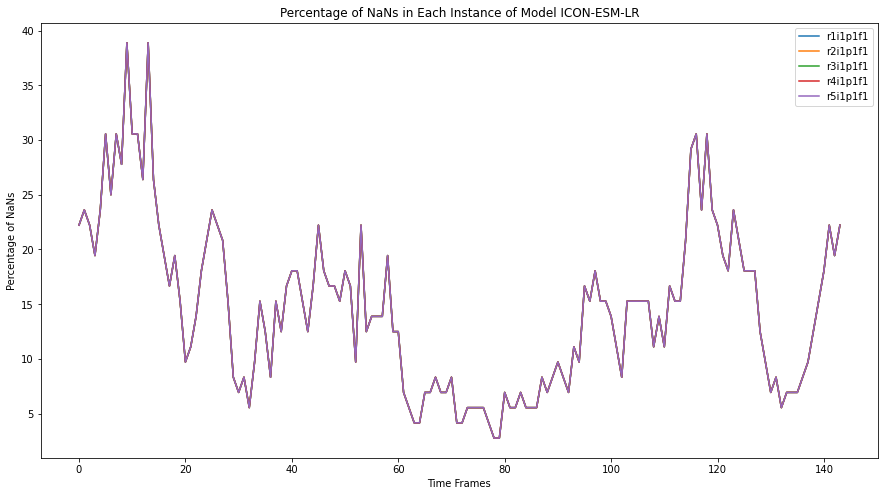

In [14]:
# Function to find NaN locations in a 3D array
def Nan_percentage_per_timestamp(array):
    return np.isnan(array).sum(axis=(0, 1)) / (array.shape[0] * array.shape[1]) * 100

# Prepare data for plotting
nan_percentages = {}

# Iterate through each instance in the model
for instance in model_test.keys():
    instance_data = model_test[instance]
    nan_percentage = Nan_percentage_per_timestamp(instance_data)
    nan_percentages[instance] = nan_percentage

# Plot the percentage of NaNs for each instance
plt.figure(figsize=(15, 8))
for instance, nan_percentage in nan_percentages.items():
    plt.plot(nan_percentage, label=instance)

plt.xlabel('Time Frames')
plt.ylabel('Percentage of NaNs')
plt.title(f'Percentage of NaNs in Each Instance of Model {list(data.keys())[0]}')
plt.legend()
plt.show()

In [15]:
# Plot the temperature evolution of a particular grid cell

middle_x = model_test['r1i1p1f1'].shape[0] // 2
middle_y = model_test['r1i1p1f1'].shape[1] // 2
print(f"middle_x: {middle_x}, middle_y: {middle_y}")

middle_grid_data = {}

for instance in model_test.keys():
    instance_data = model_test[instance]
    middle_grid_data[instance] = instance_data[middle_x, middle_y, :]

middle_x: 82, middle_y: 36


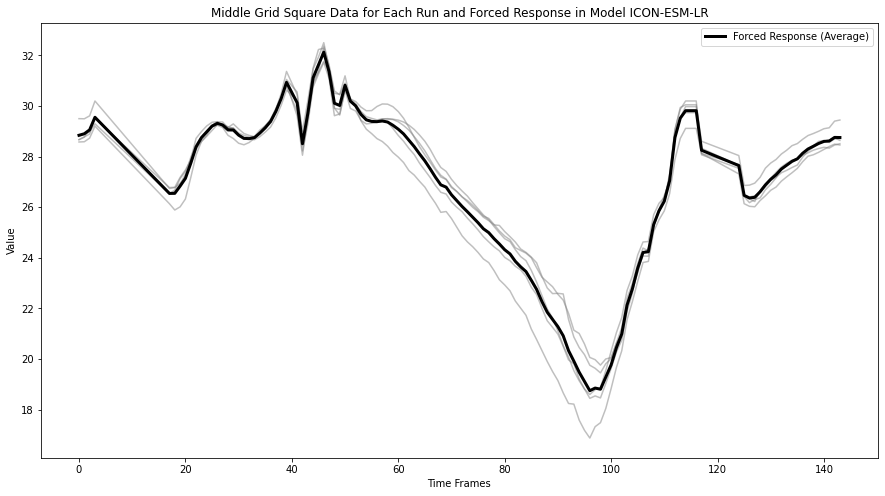

In [17]:
# Plotting the middle grid square data for each instance
def fill_nans(array):
    df = pd.DataFrame(array)
    return df.interpolate(method='linear', axis=0).interpolate(method='linear', axis=1).to_numpy()

# Fill NaNs and prepare data for plotting
filled_middle_grid_data = {}
for instance, middle_data in middle_grid_data.items():
    filled_middle_grid_data[instance] = fill_nans(middle_data)

# Calculate the forced response (average of the runs)
forced_response = np.nanmean(list(filled_middle_grid_data.values()), axis=0)


plt.figure(figsize=(15, 8))
for middle_data in filled_middle_grid_data.values():
    plt.plot(middle_data, color='gray', alpha=0.5)
plt.plot(forced_response, label='Forced Response (Average)', linewidth=3, color='black')

plt.xlabel('Time Frames')
plt.ylabel('Value')
plt.title(f'Middle Grid Square Data for Each Run and Forced Response in Model {list(data.keys())[0]}')
plt.legend()
plt.show()

## Doing interpolation over the full grid

In [66]:
def fill_nans(array):
    """
    Summary: Fill NaNs in a 3D array using linear interpolation.

    Args:
        array : 3D numpy array with NaN values to be filled.

    Returns:
        array: 3D numpy array with NaN values filled using linear interpolation.
    """
    reshaped_df = pd.DataFrame(array.reshape(-1, array.shape[-1])) # Reshape into a 2D array of size (W*H, T)
    
    interpolated_df = reshaped_df.interpolate(method='linear', axis=1) # Interpolate the NaNs in each column
    
    # This doesn't take into account edge cases (i.e where the first/last values in the time series(s) are NaNs)
    
    interpolated_df = interpolated_df.fillna(method='bfill', axis = 1)
    
    interpolated_df = interpolated_df.fillna(method='ffill', axis = 1)
    
    # Check if there are any NaN values in the array
    assert(interpolated_df.isnull().values.any() == False)  
    
    return interpolated_df.values.reshape(array.shape)

Random grid points: [(36, 68), (125, 13), (154, 36), (24, 53), (41, 60)]


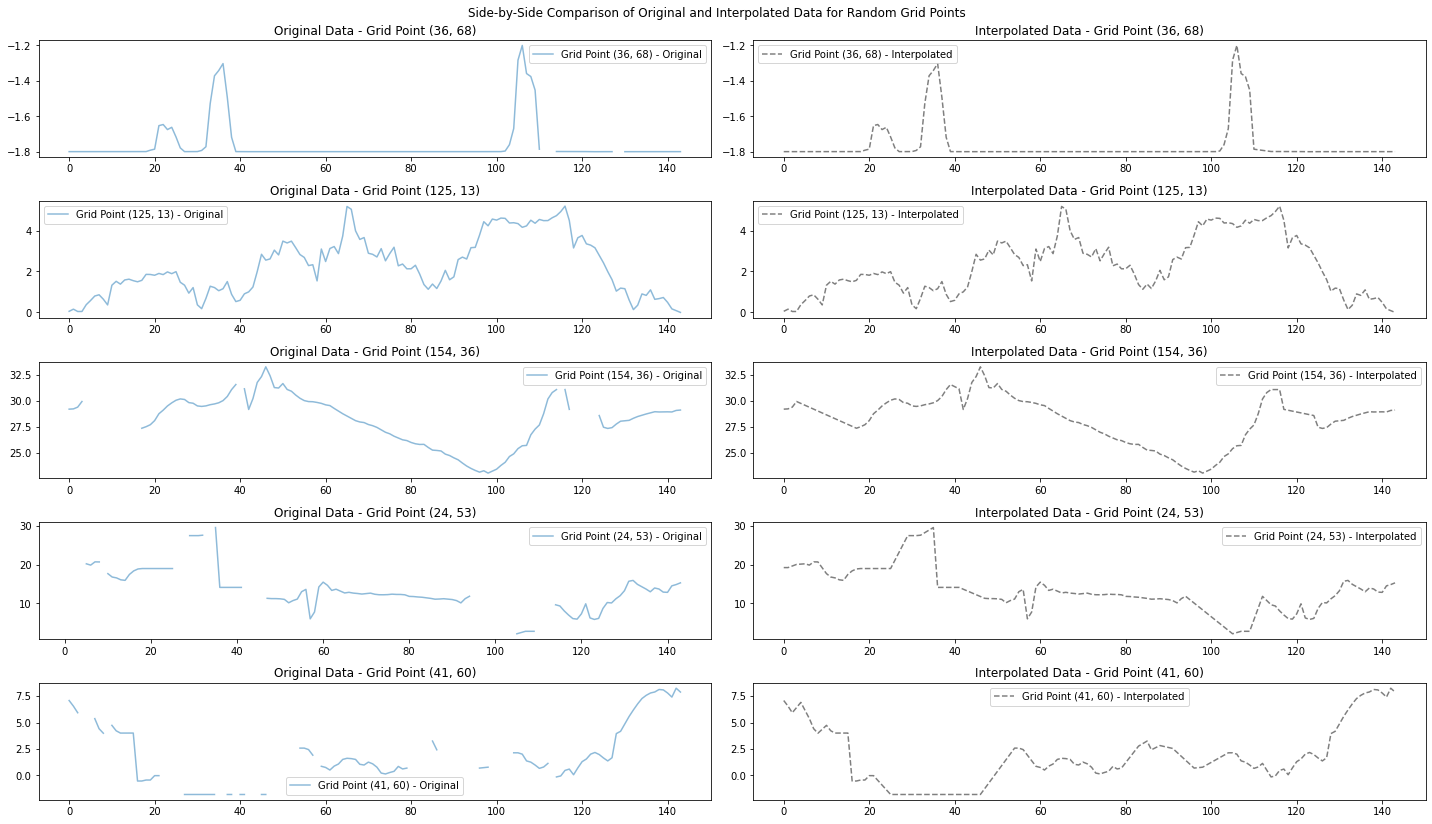

In [67]:
test_array_full = model_test['r1i1p1f1']

interpolated_array = fill_nans(test_array_full)

# Store the randomly selected grid points
random_grid_points = [(np.random.randint(0, test_array_full.shape[0]), np.random.randint(0, test_array_full.shape[1])) for _ in range(5)]
print(f"Random grid points: {random_grid_points}")

plt.figure(figsize=(20, 12))
for i, (x, y) in enumerate(random_grid_points):
    # Plot original data
    plt.subplot(5, 2, 2*i+1)
    plt.plot(test_array_full[x, y, :], label=f'Grid Point ({x}, {y}) - Original', alpha=0.5)
    plt.title(f'Original Data - Grid Point ({x}, {y})')
    plt.legend()
    
    # Plot interpolated data
    plt.subplot(5, 2, 2*i+2)
    plt.plot(interpolated_array[x, y, :], color='black', linestyle='dashed', label=f'Grid Point ({x}, {y}) - Interpolated', alpha=0.5)
    plt.title(f'Interpolated Data - Grid Point ({x}, {y})')
    plt.legend()
    
plt.suptitle('Side-by-Side Comparison of Original and Interpolated Data for Random Grid Points')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

## Calculating the forced response of this model

In [68]:
print(model_test.keys())

# check that all sizes are the same for all the runs
sizes = [model_test[model].shape for model in model_test.keys()]
assert(len(set(sizes)) == 1) # Checks if all the shapes are the same
print("All runs have the same shape.")

dict_keys(['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1'])
All runs have the same shape.


In [69]:
# Fill NaN values for all models
interpolated_models_list = [{"model_name" : model, "interpolated_data" : fill_nans(model_test[model])} for model in model_test.keys()]